# Hands On

## Set Up

In [14]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

## Load MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [ ]:
print(mnist['DESCR'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
print(28*28)

(70000, 784)
(70000,)
784


In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Plot a Digit

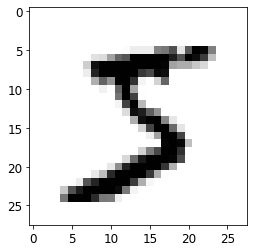

In [7]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")

plot_digit(X[0])

## Question 1

**Build a classifier for MNIST that gets over 97% accuracy on test set.**

*Hint: KNN works well, perform a grid search to find optimal hyper parameters.*



**Running the grid search takes several hours!**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"weights": ["uniform", "distance"], 'n_neighbors': [3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)

**Run these cells with the best parameters.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# from the grid search
best_params = {'n_neighbors': 4, "weights": "distance"}

knn_clf_best = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"], weights=best_params["weights"])
knn_clf_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [9]:
from sklearn.metrics import accuracy_score

y_knn_pred = knn_clf_best.predict(X_test)
accuracy_score(y_test, y_knn_pred)

0.9714

## Question 2

**Write a function that shifts an MNIST image up, down, left, and right. Then create 4 shifted copies for each image and add to the MNIST training set. Train the best model on the expanded set and measure accuracy on test set.**

*This technique is called "data augmentation".*

### Write the function with scipy image shift.

In [18]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy,dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


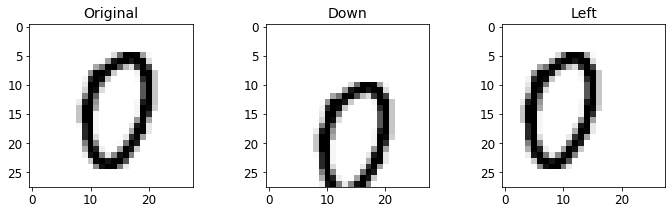

In [19]:
some_digit = X_train[1000]
shift_down = shift_image(some_digit, 0, 5)
shift_left = shift_image(some_digit, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plot_digit(some_digit)
plt.subplot(132)
plt.title("Down", fontsize=14)
plot_digit(shift_down)
plt.subplot(133)
plt.title("Left", fontsize=14)
plot_digit(shift_left)

### Augment the dataset with shifted images

In [20]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy, in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [21]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [22]:
X_train_augmented.shape

(300000, 784)

In [23]:
X_train.shape

(60000, 784)

### Train, predict, and score a KNN with augmented data

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_params = {'n_neighbors': 4, "weights": "distance"}

knn_clf_augmented = KNeighborsClassifier(**best_params)
knn_clf_augmented.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [27]:
y_pred = knn_clf_augmented.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred)

0.9763

## Question 3

**Tackle the titanic dataset on Kaggle. Make the best model possible and upload to Kaggle to see final score.**

*Predict passenger survival.*

https://www.kaggle.com/c/titanic/data

### Load Data

In [5]:
import os 

print(os.getcwd())
TITANIC_PATH = os.path.join("datasets", "titanic")
print(TITANIC_PATH)

/home/mlr/Desktop/repos/ml_noteooks
datasets/titanic


In [6]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [7]:
# data is already split
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Description

The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic


### Inspect Data

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


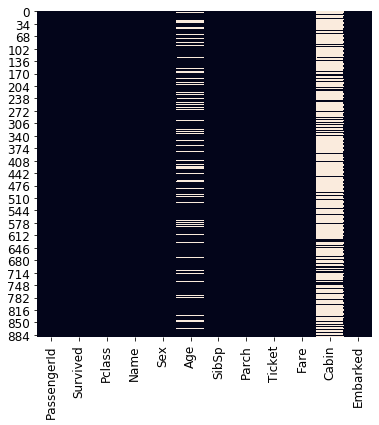

In [15]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(train_data.isnull(), cbar=False)

In [17]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Only 38% **Survived**. That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

In [18]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [19]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [20]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [21]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Preprocessing Pipeline

*Note: Rewrite with ColumnTransformer*

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# numerical features
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [27]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [28]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [29]:
from sklearn.preprocessing import OneHotEncoder

# categorical features
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [30]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [32]:
from sklearn.pipeline import FeatureUnion

# combine numerical and categorical processing
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [33]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [34]:
# pull labels from data
y_train = train_data["Survived"]

### Train a SVM

In [37]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [38]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [39]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

### Train a Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

### Visualize CV scores

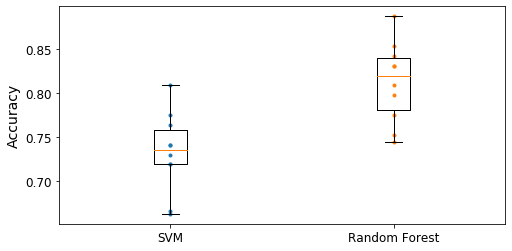

In [40]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

### Feature Egineering

In [41]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [42]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Question 4

**Build a spam classifier.**

*This is a challenging exercise...*